In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

In [3]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the spectrum of the windowed input signal
  spectrum = fft(sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  plt.plot(magnitude_spectrum)
  plt.ylabel('amplitude (dB)')
  plt.show()

def signal2pytorch(x):
    #Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals)
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [4]:
# define model graph

class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        # Analysis Filterbank with downsampling of N=1024, filter length of 2N, but only N/2 outputs:
        self.conv1=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=1024, padding=1023, bias=True) #Padding for 'same' filters (kernel_size/2-1)

        #Synthesis filter bank, deconvolution
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # pass the input signal through the convolutional layer
        x = self.conv1(x)
        # use the tanh activation function
        y = torch.tanh(x)
        return y

    def decoder(self, y):
        # Synthesis
        xrek= self.synconv1(y)
        return xrek

    def forward(self, x):
        y=self.encoder(x)
        xrek=self.decoder(y)
        return xrek

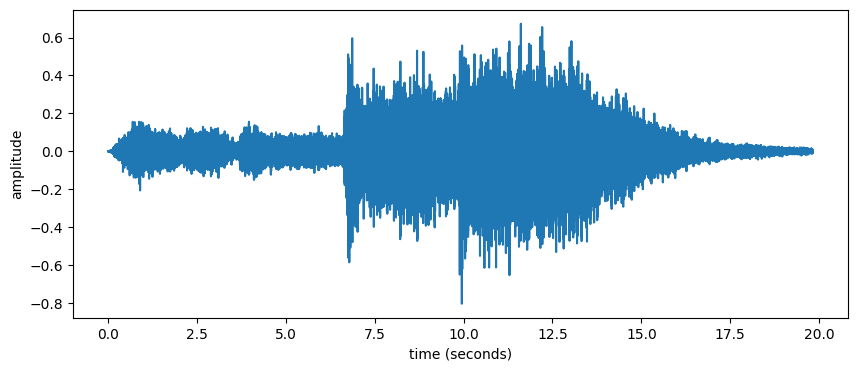

In [5]:
# read training data
batch=1
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")
X_train = signal2pytorch(audio1).to(device)
display_sound(audio1, samplerate)

In [6]:
# Generate Model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()

Ypred = model(X_train)

# length of the signal at the output of the network.
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)

# the target signal with same length as model output
Y=X_train[:,:,:outputlen]

print("Input X.shape =", X_train.shape)
print("Target Y.shape =", Y.shape)
print("Target Y =", Y)
print("Y.type() =", Y.type())

Total number of parameters: 131105
outputlen= 873474
Input X.shape = torch.Size([1, 1, 874006])
Target Y.shape = torch.Size([1, 1, 873474])
Target Y = tensor([[[-0.0003, -0.0003, -0.0003,  ..., -0.0068, -0.0069, -0.0069]]])
Y.type() = torch.FloatTensor


In [7]:
# train model
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Ypred = model(X_train)
print("Ypred=", Ypred)

# train the model over a number of epochs
nepocs = 2000
for epoch in range(nepocs):
  Ypred=model(X_train)
  loss=loss_fn(Ypred, Y)
  if epoch%10==0:
    print(epoch, loss.item())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Ypred= tensor([[[0.0176, 0.0162, 0.0157,  ..., 0.0177, 0.0182, 0.0149]]],
       grad_fn=<ConvolutionBackward0>)
0 0.010117239318788052
10 0.009808306582272053
20 0.00926025491207838
30 0.00840457621961832
40 0.00743757002055645
50 0.00658915052190423
60 0.0059057921171188354
70 0.005350469145923853
80 0.004920402076095343
90 0.0046093822456896305
100 0.004391276743263006
110 0.004237177781760693
120 0.004122394602745771
130 0.004029214382171631
140 0.003946887794882059
150 0.0038690115325152874
160 0.003791798371821642
170 0.0037131826393306255
180 0.0036322048399597406
190 0.0035486004780977964
200 0.003462520893663168
210 0.00337435700930655
220 0.003284645499661565
230 0.0031940455082803965
240 0.003103335853666067
250 0.003013397566974163
260 0.0029251461382955313
270 0.002839429536834359
280 0.0027569225057959557
290 0.0026780522894114256
300 0.0026029853615909815
310 0.0025316616520285606
320 0.0024638643953949213
330 0.002399296034127474
340 0.0023376350291073322
350 0.00227857

ww= OrderedDict({'conv1.weight': tensor([[[-0.0348, -0.0291, -0.0184,  ..., -0.0145, -0.0421, -0.0443]],

        [[ 0.0269,  0.0254,  0.0140,  ..., -0.0012,  0.0080, -0.0036]],

        [[ 0.0446,  0.0396,  0.0453,  ...,  0.0215,  0.0097,  0.0141]],

        ...,

        [[-0.0076, -0.0105, -0.0187,  ..., -0.0203,  0.0089, -0.0280]],

        [[ 0.0715,  0.0631,  0.0436,  ...,  0.0232,  0.0053,  0.0241]],

        [[-0.0281, -0.0258, -0.0295,  ...,  0.0621,  0.0444,  0.0655]]]), 'conv1.bias': tensor([ 1.3170e-04, -9.9465e-04, -1.8543e-04, -6.0472e-04,  1.2529e-03,
        -9.0541e-04, -8.9153e-04,  8.8190e-04,  7.5403e-04,  1.3884e-03,
        -5.0538e-04, -1.8542e-03, -3.8801e-05, -1.1272e-03,  3.7142e-04,
         8.4012e-04,  2.1715e-03, -2.1165e-03,  4.3965e-04, -4.1235e-04,
         8.6765e-04, -9.6947e-04,  1.3359e-03,  1.1927e-04, -3.2222e-04,
        -6.0579e-04, -1.2350e-03,  1.9777e-03, -2.6263e-03,  8.0031e-04,
         1.9953e-03,  5.5633e-04]), 'synconv1.weight': tensor(

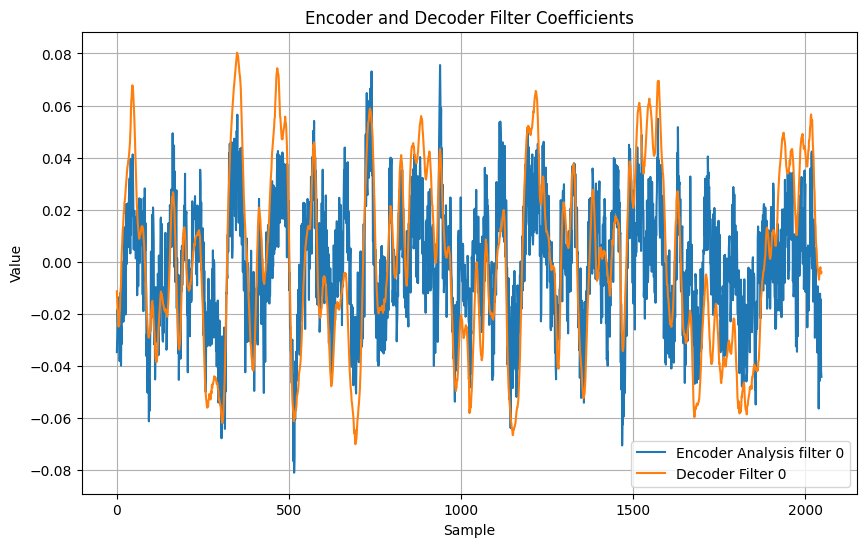

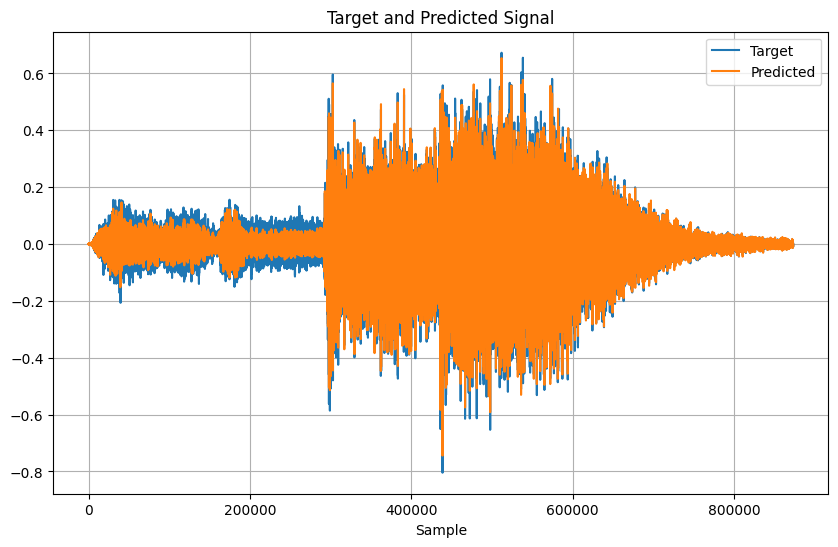

In [8]:
# Make predictions using the training set

# Read obtained weights
ww = model.state_dict()
print("ww=", ww)

# Plot obtained weights:
plt.figure(figsize=(10,6))

# Convert weights from PyTorch tensors to NumPy arrays and plot
conv1_weights = ww['conv1.weight'][0:1, 0, :].detach().cpu().numpy()
synconv1_weights = ww['synconv1.weight'][0:1, 0, :].detach().cpu().numpy()

plt.plot(np.transpose(conv1_weights))
plt.plot(np.transpose(synconv1_weights))

plt.legend(('Encoder Analysis filter 0', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.grid()

# Make Predictions based on the obtained weights, on training set
predictions = model(X_train).cpu().detach().numpy()  # Convert predictions to NumPy

Y = Y.detach().cpu().numpy() if isinstance(Y, torch.Tensor) else np.array(Y)  # Ensure Y is NumPy

print("predictions.shape=", predictions.shape)

# Plot target signal and output of autoencoder:
plt.figure(figsize=(10,6))
plt.plot(Y[0, 0, :])  # Target signal
plt.plot(predictions[0, 0, :])  # Predicted signal

plt.legend(('Target', 'Predicted'))
plt.title('Target and Predicted Signal')
plt.xlabel('Sample')
plt.grid()

# Remove unnecessary dimension for playback
xrek = predictions[:, 0, :]  # This should be fine if you only want to drop the middle dimension

In [9]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))

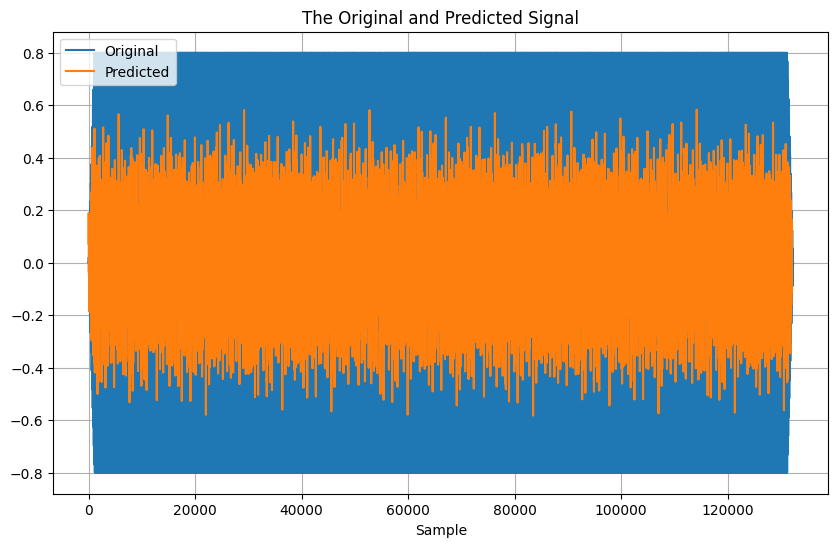

In [12]:
# Test on data different from the training one
# audio2, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("../sounds/sinewave.wav")

# Convert the audio signal to PyTorch format and move it to the correct device
X_test = signal2pytorch(audio2).to(device)  # Convert to PyTorch format, with batch as the first dimension

# Make Predictions based on the obtained weights, on the verification set
predictions = model(X_test).cpu().detach().numpy()  # Detach, move to CPU, and convert to NumPy

# Plot the original and predicted signal
plt.figure(figsize=(10,6))

# Convert X_test to NumPy for plotting, after detaching and moving to CPU
X_test_np = X_test.cpu().detach().numpy()

plt.plot(X_test_np[0, 0, :])  # Plot original signal
plt.plot(predictions[0, 0, :])  # Plot predicted signal

plt.legend(('Original', 'Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()

# Remove unnecessary dimension for playback
xrek = predictions[:, 0, :]  # Remove the middle dimension


In [11]:
#play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(xrek, rate=samplerate))